# App Identification

## Table of content 

0. Introduction
1. Setup
2. Dataset size investigation
3. Outliers Detections

## Introduction

## Setup

In [144]:
import pandas as pd
import numpy as np
import sys
import random
from build_datasets import *
%matplotlib inline
DEVICES_TO_INCLUDE = ['LEO-BX9']
TEST_PERCENTAGE = 0.25
import sys
from tqdm import tqdm
import numpy as np
from scipy.spatial.distance import euclidean
from scipy.cluster.hierarchy import linkage, dendrogram
from fastdtw import fastdtw
import build_datasets
import scipy.spatial.distance as ssd
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
from scipy.special import comb
import csv
import glob
import math
import os
import pickle
import sys
from functools import reduce
import copy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import kurtosis
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils.multiclass import unique_labels

DATA_PATH = "./data/open-3/"
WATCH_NAME = 'LEO-BX9'
REBUILD = True

In [470]:
def build_features_labels_dataset(events, adversary_capture_duration=-1):
    data = []
    labels = []
    for device in events:
        for app in events[device]:
            for action in events[device][app]:
                label = app + "_" + action
                for event in events[device][app][action]:
                    features_dict = extract_features(event, adversary_capture_duration)
                    features = list(features_dict.values())
                    data.append(features)
                    labels.append(label)

    return data, labels


def create_sub_dataset(datasets, N_TO_PICK = -1, AppToKeepOnly="all"):
    datasets_to_analysis = []
    labels_to_analysis = []
    
    for watch in datasets:
        for app in datasets[watch]:
            if AppToKeepOnly != "all" and app not in AppToKeepOnly:
                continue
            for action in datasets[watch][app]:
                label= WATCH_NAME +"_"+app+"_"+action
                

                events = datasets[watch][app][action]
                chosen_events = []
                if type(datasets[watch][app][action]) is dict:
                    events = list(events.keys())

                if N_TO_PICK == -1 or len(events) < N_TO_PICK:
                    chosen_events = random.sample(events, len(events_nb))
                    if N_TO_PICK != -1:
                        print("N_TO_PICK too large. Took all the dataset for " + app + "_" + action ," instead")
                    chosen_events = random.sample(events, N_TO_PICK)

                if type(datasets[watch][app][action]) is dict:
                    labels_to_analysis += [label + "_" + nb for nb in chosen_events]
                    datasets_to_analysis += [datasets[watch][app][action][event_nb] for event_nb in chosen_events]
                else:
                    labels_to_analysis += [label for nb in chosen_events]
                    datasets_to_analysis += events
                
    return datasets_to_analysis, labels_to_analysis

def extract_features(xy, capture_duration_does_nothing=0): # dataset is {'xs': [packet1, packet2,...], 'ys': [packet1, packet2,...]} where x is time and y is size
    xs = xy['xs']
    ys = xy['ys']
    f = dict()

    def take(arr, n=30):
        if len(arr) > n:
            return arr[:30]
        return arr

    def stats(key, data):
        if len(data) == 0:
            data=[-1]
        f['min_'+key] = np.min(data)
        f['mean_'+key] = np.mean(data)
        f['max_'+key] = np.max(data)
        f['count_'+key] = len(data)
        f['std_'+key] = np.std(data)
        f['kurtosis_'+key] = kurtosis(data)



    # general statistics
    stats("non_null", [abs(y) for y in ys if y != 0])
    stats("outgoing", [abs(y) for y in ys if y > 0])
    stats("incoming", [abs(y) for y in ys if y < 0])
    stats("outgoing_30", [abs(y) for y in take(ys) if y > 0])
    stats("incoming_30", [abs(y) for y in take(ys) if y < 0])

    f["total_payload"] = sum([abs(y) for y in ys])

    # statistics about timings
    x_deltas = []
    i = 1
    while i<len(xs):
        x_deltas.append(xs[i]-xs[i-1])
        i += 1

    stats("x_deltas", x_deltas)
    stats("x_deltas_30", take(x_deltas))

    # bursts

    # unique packet lengths [Liberatore and Levine; Herrmann et al.]
    lengths = dict()
    for i in range(500,1000):
        lengths[str(i)] = 0
    for y in ys:
        if str(abs(y)) in lengths:
            lengths[str(abs(y))] += 1

    lengths_array = list(lengths.values())
    stats("unique_lengths", lengths_array)
    for l in lengths:
        f['unique_lengths_'+str(l)] = lengths[l]


    return f


def compute_dtw(s1, s2, remove_zeros = True):
    xs1, ys1 = s1["xs"], s1["ys"]
    
    if remove_zeros:
        xys1 = [[x, y] for x, y in zip(xs1, ys1) if y != 0]
    else:
        xys1 = [[x, y] for x, y in zip(xs1, ys1)]
        
    xs2, ys2 = s2["xs"], s2["ys"]
    if remove_zeros:
        xys2 = [[x, y] for x, y in zip(xs2, ys2) if y != 0]
    else:
        xys2 = [[x, y] for x, y in zip(xs2, ys2)]
    
    if len(xys1) == 0:
        xys1 = [0]
    if len(xys2) == 0:
        xys2 = [0]
    distance, path = fastdtw(xys1, xys2, dist=euclidean)
    return distance


def compute_distance_mat(datasets_to_analysis, remove_zeros = True):
    dtw_mat = np.zeros((len(datasets_to_analysis), len(datasets_to_analysis)))
    for i, s1 in enumerate(datasets_to_analysis):
        print(i , "/", len(datasets_to_analysis))
        for j in range(i,len(datasets_to_analysis)):
            if i == j:
                continue
            s2 = datasets_to_analysis[j]

            dtw =  int(compute_dtw(s1, s2, remove_zeros) )
            dtw_mat[i,j] = dtw
            dtw_mat[j,i] = dtw
    return dtw_mat

def hierarchical_clustering(dtw_mat):
    dist_array = ssd.squareform(dtw_mat)
    Z = linkage(dist_array, method="ward", optimal_ordering = True)
    return Z

def plot_dendograme(Z, fname):

    fig = plt.figure(figsize=(170, 40))
    ax = fig.add_subplot(1, 1, 1)
    dendrogram(Z, ax=ax, labels = labels_to_analysis, leaf_font_size=40)#, p=13, truncate_mode = "level")
    #ax.tick_params(axis='x', which='major', labelsize=40)
    ax.tick_params(axis='y', which='major', labelsize=40)
    plt.yscale('symlog')
    fig.savefig(fname)
    

def exclude(d):
    device = d.replace(DATA_PATH, '')
    device = device[:device.find('_')]
    return device in DEVICES_TO_INCLUDE


def filter_by_length(events, minimum_payload=500, ratio_app_not_satisfing_minimum_payload_length=0.25, printInfo = False):
    results = copy.deepcopy(events)
    for watch in events:
        for app in events[watch]:
            for action in events[watch][app]:
                total_event = len(events[watch][app][action])
                bellow_minimum_payload = 0
                for sample in events[watch][app][action]:
                   
                    payload_length = sum([abs(s) for s in sample["ys"]])
                    if payload_length < minimum_payload:
                        bellow_minimum_payload += 1
                        
                ratio_bellow = bellow_minimum_payload / total_event
                if ratio_bellow > ratio_app_not_satisfing_minimum_payload_length:
                    if printInfo:
                        print("total_event: ", total_event, " - bellow threshold: ", bellow_minimum_payload)
                        print(app + "_" + action + " removed")
                        print(" ratio_below = ", ratio_bellow)
                    del results[watch][app][action]
                    
            if len(results[watch][app]) == 0:
                del results[watch][app]
    return results


def filer_by_data_size(events, N_TO_PICK):
    
    results = copy.deepcopy(events)
    for watch in events:
        for app in events[watch]:
            for action in events[watch][app]:
                if len(events[watch][app][action]) < N_TO_PICK:
                    print("N_TO_PICK too large. Took all the dataset for " + app + "_" + action ," instead")
                    continue
                else:
                    chosen_indices = random.sample(range(len(events[watch][app][action])), N_TO_PICK)
                    chosen_events = list(np.array(events[watch][app][action])[chosen_indices])
                results[watch][app][action] = chosen_events
    return results

def plot_confusion_matrix(y_true, y_pred,
                          normalize=True,
                          title=True):

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = unique_labels(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(20, 20), dpi= 180)
    ax.imshow(cm, interpolation='none', aspect='auto', cmap=plt.cm.Blues)


    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")

    ax.set(xticks=np.arange(cm.shape[1]),
            yticks=np.arange(cm.shape[0]),
            # ... and label them with the respective list entries
            xticklabels=classes, yticklabels=classes,
            title=title,
            ylabel='True label',
            xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    #plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
    #         rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    return cm, fig, ax
                

## Import all the dataset



In [410]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

sources_files = find_sources(DATA_PATH)
all_sources_files = list(filter(exclude, sources_files))
events, counts = cut_all_datasets_in_events(sources_files)
filtered_events = filter_by_length(events)
X, y = build_features_labels_dataset(filtered_events)

## Dataset size 

Investigation of how little the size of the dataset can be without hurting to much accurancy

In [ ]:
n_splits = 5
repeat = 10
accuracies = []
n_samples = []
conf_95 = []
for i in range(2, 41):
    print("Keep only ",i, " samples per category")
    for _ in range(repeat):
        
        reduced_events = filer_by_data_size(filtered_events, i)
        X, y = build_features_labels_dataset(reduced_events)
        clf=RandomForestClassifier(n_estimators=100, random_state=None)
        shuf_split = ShuffleSplit(n_splits=5, test_size=0.25, random_state=0)

        scores_shuffle = cross_val_score(clf, X, y, cv=shuf_split)
        #scores_determined = cross_val_score(clf, X, y, cv=5)
        print("Random %d split Accuracy: %0.2f (+/- %0.2f)" % (n_splits, scores_shuffle.mean(), scores_shuffle.std() * 2))
        n_samples.append(i)
        accuracies.append(scores_shuffle.mean())
        conf_95.append(scores_shuffle.std() * 2)

In [407]:
# Compute the mean over realisations
n_samples = np.array(n_samples)
accuracies = np.array(accuracies)
conf_95 = np.array(conf_95)

n_samples_repr = n_samples.reshape((-1,10))[:,0]
accuracies_avg = accuracies.reshape((-1,10)).mean(axis = 1)
conf_95_avg = conf_95.reshape((-1,10)).mean(axis = 1)

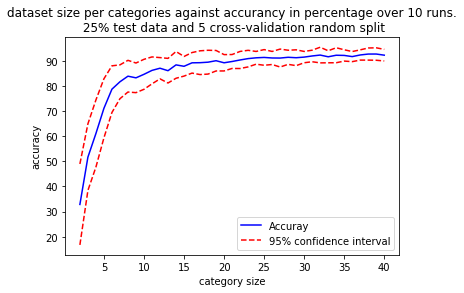

In [409]:
accuracies_percentage = [a * 100 for a in accuracies_avg]
conf_95_per = [a * 100 for a in conf_95_avg]
conf_upper = [x + y for x, y in zip(accuracies_percentage, conf_95_per)]
conf_lower = [x - y for x, y in zip(accuracies_percentage, conf_95_per)]
fig, ax = plt.subplots()
ax.plot(n_samples_repr, accuracies_percentage, '-b', label='Accuray')
ax.plot(n_samples_repr, conf_upper, '--r', label='95% confidence interval')
ax.plot(n_samples_repr, conf_lower, '--r')
plt.title("dataset size per categories against accurancy in percentage over 10 runs.\n 25% test data and 5 cross-validation random split")
ax.set_xlabel('category size')
ax.set_ylabel('accuracy')
leg = ax.legend()
plt.savefig("./"+"Results/accuracy_to_sample_size_10_realization.png")

In [463]:
i = 6
print("accuracies_avg[i] > accuracies_avg[i+1] = ",accuracies_avg[i] > accuracies_avg[i+1])
print("why more samples less accuracy? ")
print(n_samples_repr[i], " < ", n_samples_repr[i + 1])
print("""For n=8: we have 2 test samples and 6 train samples.\nFor n=9: we have 3 test samples and 6 train samples""")

shuf_split = ShuffleSplit(n_splits=5, test_size=0.25, random_state=0)
X = [1,2,3,4,5,6,7,8]
train, test = next(shuf_split.split(X))
print()
print("n=8: len train = " + str(len(train)) + " len test = " + str(len(test)))
X = [1,2,3,4,5,6,7,8, 9]
train, test = next(shuf_split.split(X))
print("n=9: len train = " + str(len(train)) + " len test = " + str(len(test)))

accuracies_avg[i] > accuracies_avg[i+1] =  True
why more samples less accuracy? 
8  <  9
For n=8: we have 2 test samples and 6 train samples.
For n=9: we have 3 test samples and 6 train samples

n=8: len train = 6 len test = 2
n=9: len train = 6 len test = 3


In [435]:
0.75*9

6.75

We can see that there is still a fiew outliers in the data set since splitting randomly yield a bit less accuracy but much less variance compare to the none random split where the lowest score is around 0.78 of accuracy

In [465]:
clf=RandomForestClassifier(n_estimators=100, random_state=None)
shuf_split = ShuffleSplit(n_splits=5, test_size=0.25, random_state=0)
X, y = build_features_labels_dataset(filtered_events)
scores_shuffle = cross_val_score(clf, X, y, cv=shuf_split)
scores_determined = cross_val_score(clf, X, y, cv=5)
print("Random split Accuracy: %0.2f (+/- %0.2f)" % (scores_shuffle.mean(), scores.std() * 2))
print("Detemined split Accuracy: %0.2f (+/- %0.2f)" % (scores_determined.mean(), scores.std() * 2))

Random split Accuracy: 0.92 (+/- 0.02)
Detemined split Accuracy: 0.92 (+/- 0.02)


### Plotting the confusion matrix

In [503]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=None)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print("accuracy = ", accuracy)

accuracy =  0.9282051282051282


(array([[0.92857143, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.9       , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.72727273]]),
 <Figure size 3600x3600 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a45ca9ac8>)

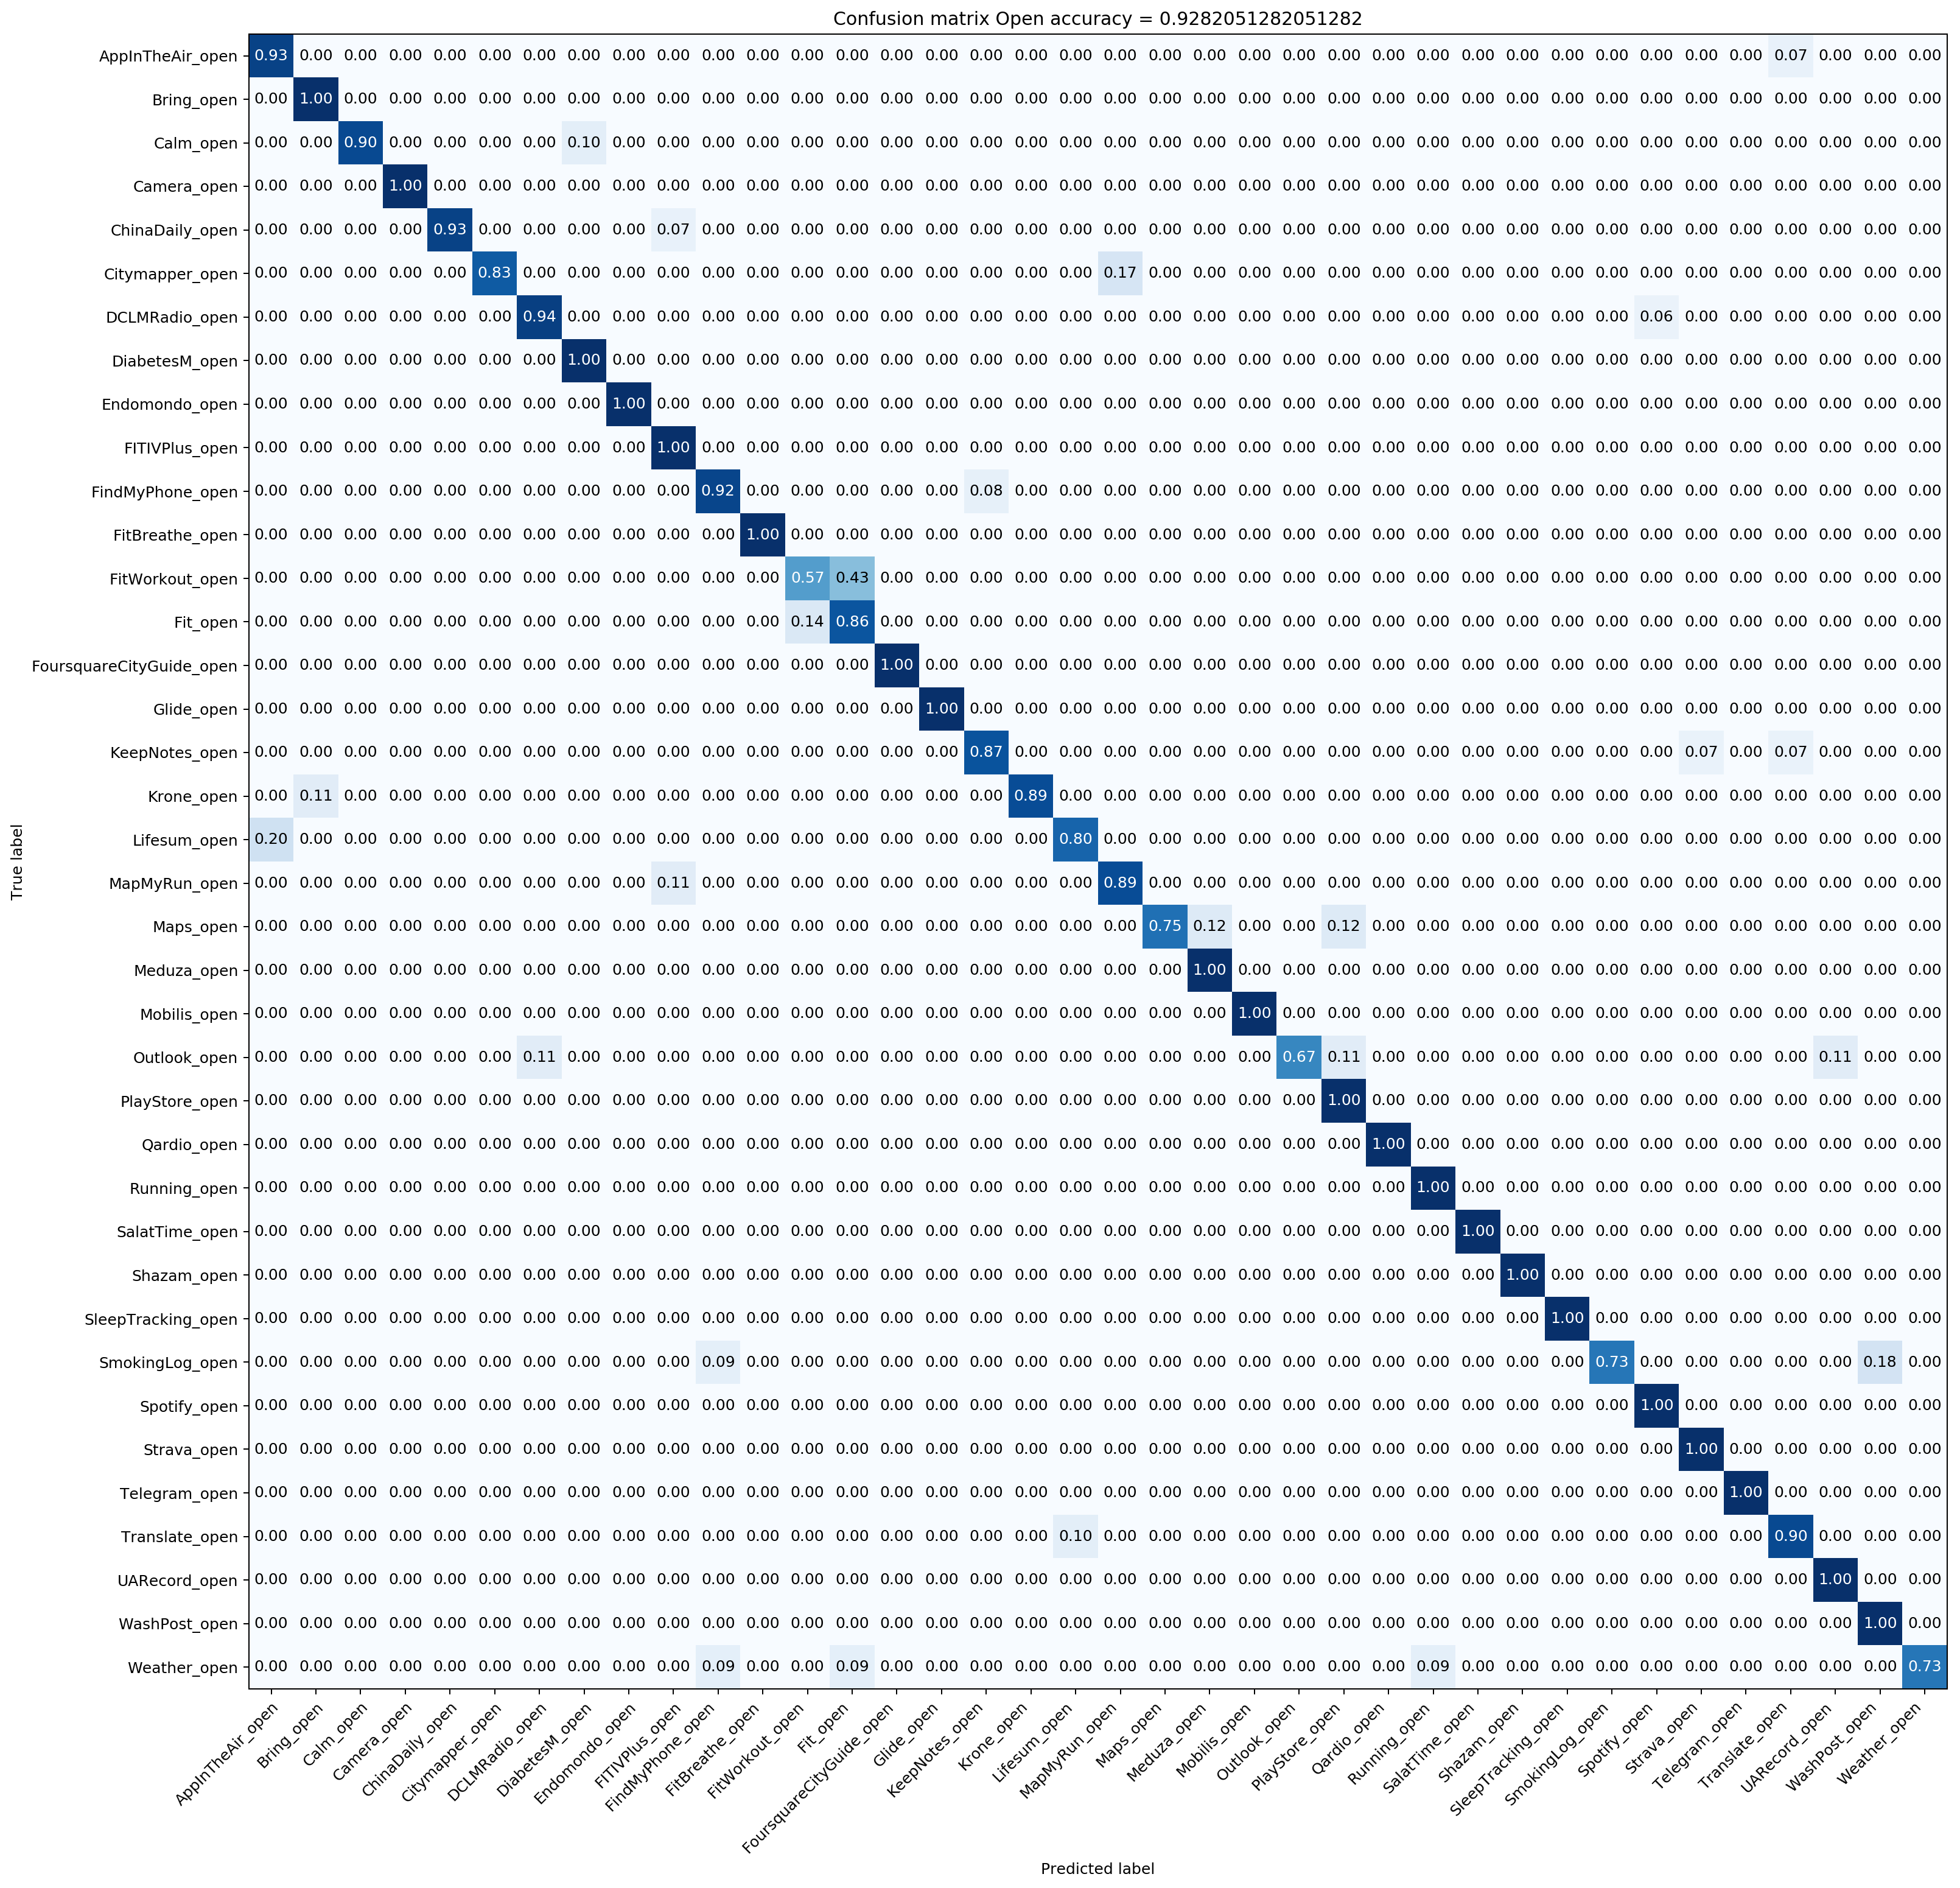

In [504]:
plot_confusion_matrix(y_test, y_pred, title= "Confusion matrix Open accuracy = " + str(accuracy))

## Outliers Detection

First investigation using DTW. Not that much conclusive. (Derived statistics might be better than raw signal operations)
Keep the study for later since we have already a very good accuracy


### Using DTW



#### Create dataset

In [40]:
sources_files = find_sources(DATA_PATH)
all_sources_files = list(filter(exclude, sources_files))
datasets, counts = cut_all_datasets_in_event(sources_files)

In [13]:
datasets_to_analysis, labels_to_analysis = create_sub_dataset(datasets, N_TO_PICK = 20, AppToKeepOnly = ["WashPost"])

In [14]:
fake_component_d, fake_component_l = create_sub_dataset(datasets, N_TO_PICK = 2, AppToKeepOnly = ["Calm"])
datasets_to_analysis = np.append(datasets_to_analysis, fake_component_d)
labels_to_analysis = np.append(labels_to_analysis, fake_component_l)

In [15]:
labels_to_analysis

array(['LEO-BX9_WashPost_open_3018', 'LEO-BX9_WashPost_open_3028',
       'LEO-BX9_WashPost_open_3034', 'LEO-BX9_WashPost_open_3040',
       'LEO-BX9_WashPost_open_3013', 'LEO-BX9_WashPost_open_3036',
       'LEO-BX9_WashPost_open_3020', 'LEO-BX9_WashPost_open_3022',
       'LEO-BX9_WashPost_open_3014', 'LEO-BX9_WashPost_open_3005',
       'LEO-BX9_WashPost_open_3003', 'LEO-BX9_WashPost_open_3009',
       'LEO-BX9_WashPost_open_3012', 'LEO-BX9_WashPost_open_3026',
       'LEO-BX9_WashPost_open_3037', 'LEO-BX9_WashPost_open_3041',
       'LEO-BX9_WashPost_open_3025', 'LEO-BX9_WashPost_open_3031',
       'LEO-BX9_WashPost_open_3017', 'LEO-BX9_WashPost_open_3038',
       'LEO-BX9_Calm_open_3034', 'LEO-BX9_Calm_open_3016'], dtype='<U26')

## Detection with 

In [16]:
dtw_mat = compute_distance_mat(datasets_to_analysis, remove_zeros=True)

0 / 22
1 / 22
2 / 22
3 / 22
4 / 22
5 / 22
6 / 22
7 / 22
8 / 22
9 / 22
10 / 22
11 / 22
12 / 22
13 / 22
14 / 22
15 / 22
16 / 22
17 / 22
18 / 22
19 / 22
20 / 22
21 / 22


In [17]:
Z = hierarchical_clustering(dtw_mat)

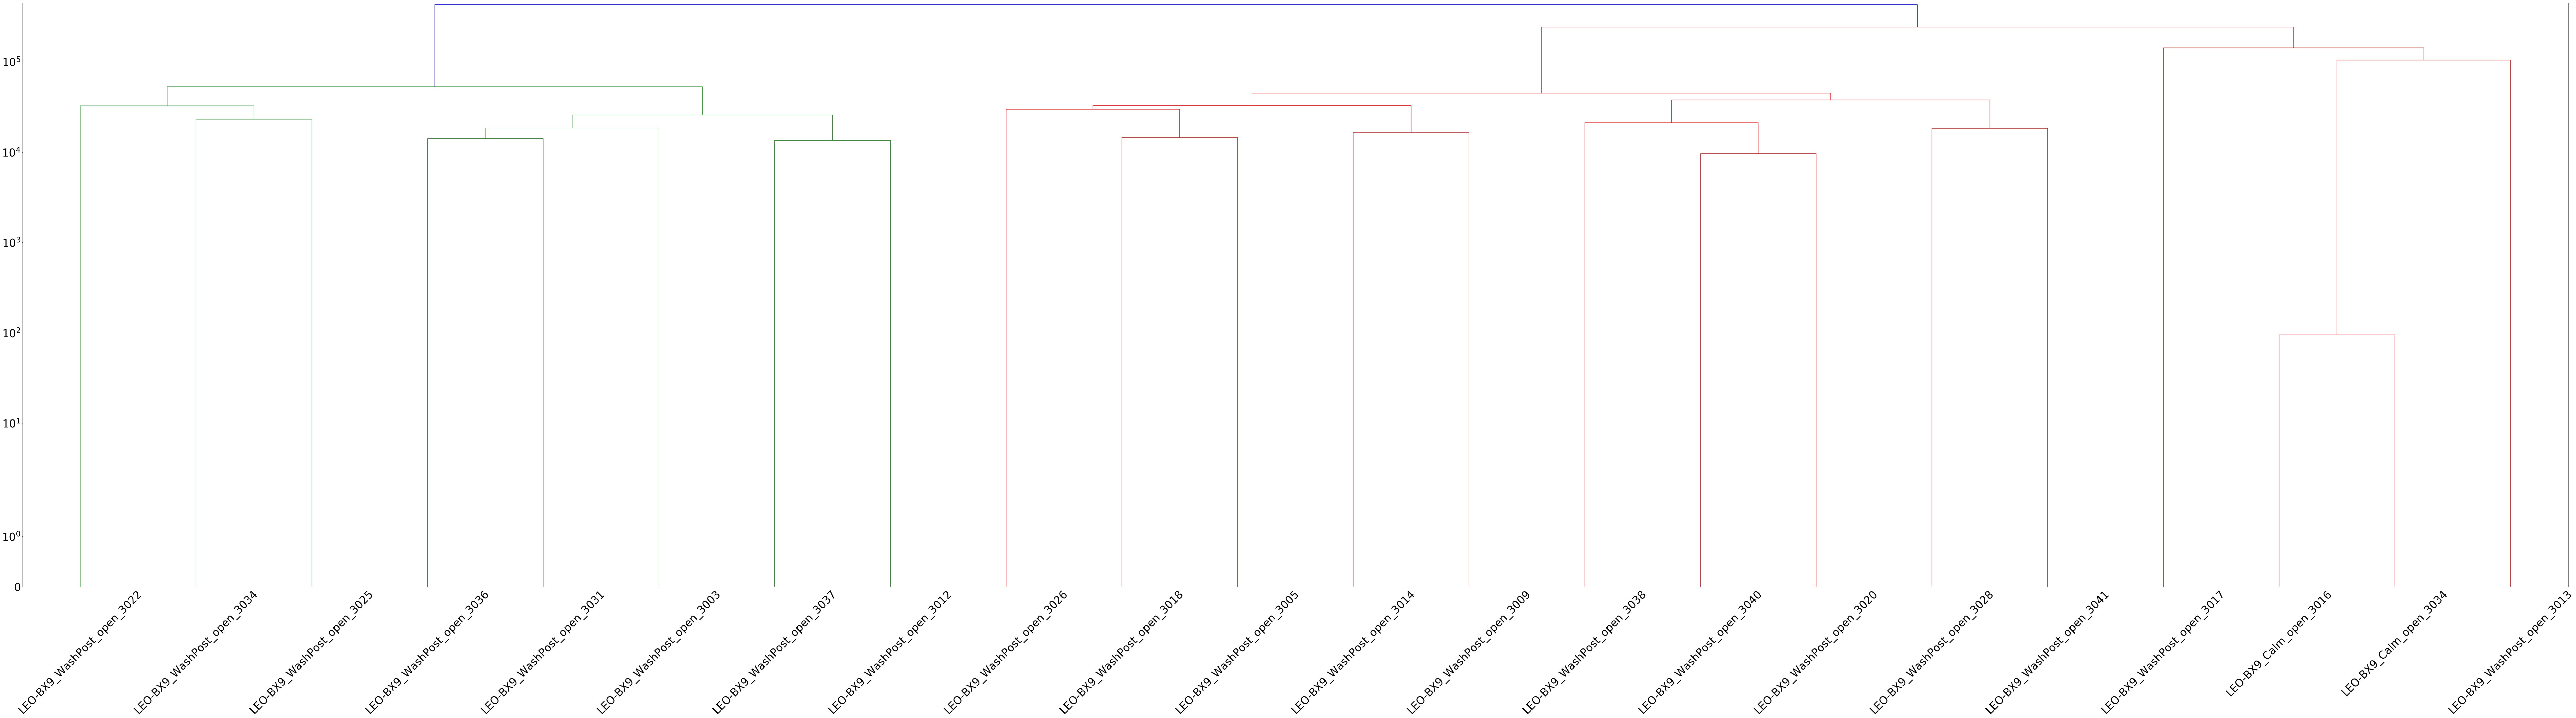

In [18]:
plot_dendograme(Z, "NoApp_NoAction_Dendogram_KeepZeros.png")

In [19]:
mean_dist = dtw_mat.mean(axis = 0).reshape(-1, 1)

In [20]:

clf = LocalOutlierFactor(n_neighbors=10)
prediction = clf.fit_predict(mean_dist)
neg_outlier_factor = clf.negative_outlier_factor_

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [21]:
outliers_ind = np.where(prediction == -1)
representative_ind = np.where(prediction == 1)
labels_to_analysis = np.array(labels_to_analysis)

less_representative_ind = np.argmin(neg_outlier_factor)
most_representative_ind = np.argmax(neg_outlier_factor)

In [22]:
outliers_val = neg_outlier_factor[outliers_ind]
less_representative = labels_to_analysis[less_representative_ind]
most_representative = labels_to_analysis[most_representative_ind]

In [23]:
print("Outliers: ", ", ".join(labels_to_analysis[outliers_ind]))
print()
print("Representatives: ", ", ".join(labels_to_analysis[representative_ind]))
print()
print(neg_outlier_factor)
print("less representative : ", less_representative)
print("most representative : ", most_representative)


Outliers:  LEO-BX9_WashPost_open_3013, LEO-BX9_WashPost_open_3009, LEO-BX9_WashPost_open_3017

Representatives:  LEO-BX9_WashPost_open_3018, LEO-BX9_WashPost_open_3028, LEO-BX9_WashPost_open_3034, LEO-BX9_WashPost_open_3040, LEO-BX9_WashPost_open_3036, LEO-BX9_WashPost_open_3020, LEO-BX9_WashPost_open_3022, LEO-BX9_WashPost_open_3014, LEO-BX9_WashPost_open_3005, LEO-BX9_WashPost_open_3003, LEO-BX9_WashPost_open_3012, LEO-BX9_WashPost_open_3026, LEO-BX9_WashPost_open_3037, LEO-BX9_WashPost_open_3041, LEO-BX9_WashPost_open_3025, LEO-BX9_WashPost_open_3031, LEO-BX9_WashPost_open_3038, LEO-BX9_Calm_open_3034, LEO-BX9_Calm_open_3016

[-0.95939442 -3.44280117 -0.93294526 -0.96329891 -3.69438062 -1.05256484
 -1.04784834 -0.9959287  -0.93334742 -1.04157811 -1.03338793 -4.04760948
 -1.05504408 -2.52785069 -1.09383932 -0.96672715 -1.15191146 -1.16992425
 -3.59528284 -0.98764496 -1.09369659 -1.05725771]
less representative :  LEO-BX9_WashPost_open_3009
most representative :  LEO-BX9_WashPost_open

In [24]:
def from_event_to_data(event, datasets):
    parts = event.split("_")
    device, app, action = parts[0], parts[1], parts[2]
    event_nb = parts[3]
    return datasets[device][app][action][event_nb]

def plot_traffic_from_sequence(sequence, title="NoTitle", color='b', timeout=10):
    plt.plot(sequence['xs'], sequence['ys'], color=color)
    plt.xlabel('Time [s]')
    plt.ylabel('Packet size [B]')
    plt.title(title)
    plt.legend()
    plt.yscale("symlog")
    plt.show()
    
def plot_event(event, datasets, color='b'):
    data = from_event_to_data(event, datasets)
    plot_traffic_from_sequence(data, title=event, color=color)
    


No handles with labels found to put in legend.


Detected outliers:


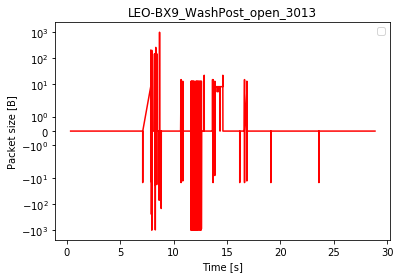

No handles with labels found to put in legend.


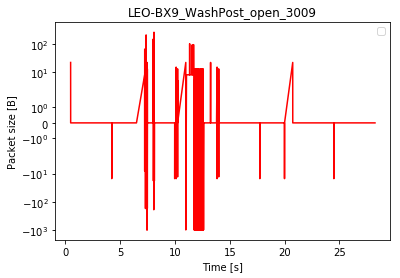

No handles with labels found to put in legend.


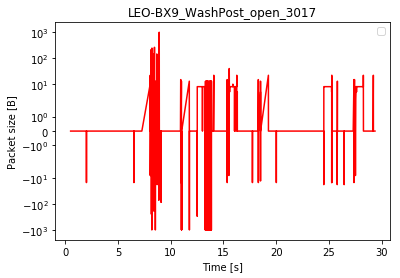

In [25]:
print("Detected outliers:")

for outlier in labels_to_analysis[outliers_ind]:
    plot_event(outlier, datasets, 'r')

No handles with labels found to put in legend.


Detected representatives:


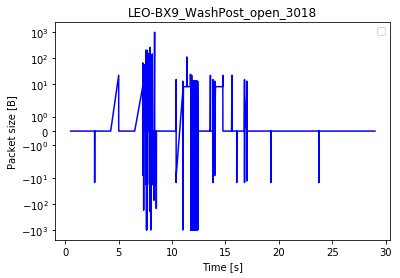

No handles with labels found to put in legend.


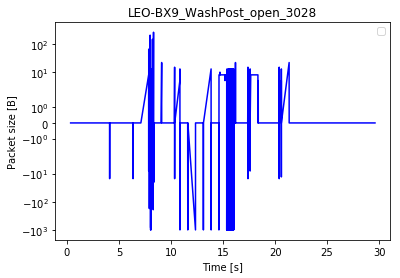

No handles with labels found to put in legend.


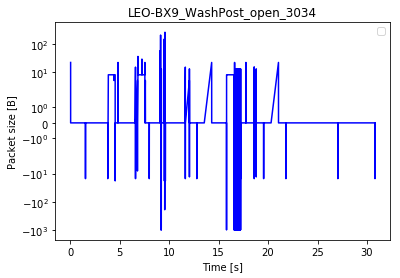

No handles with labels found to put in legend.


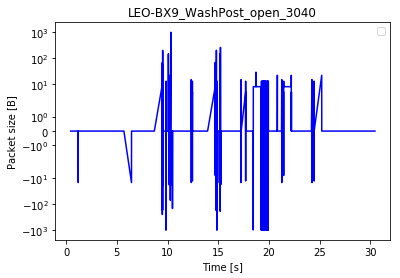

No handles with labels found to put in legend.


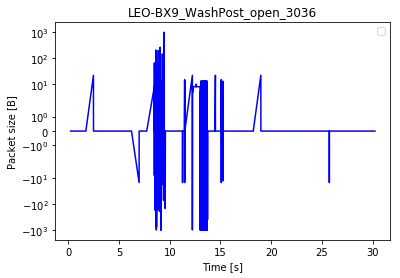

No handles with labels found to put in legend.


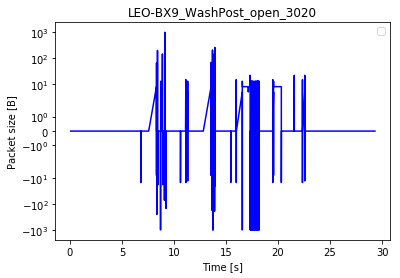

No handles with labels found to put in legend.


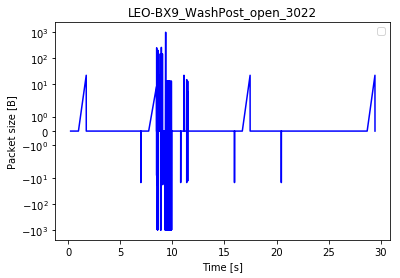

No handles with labels found to put in legend.


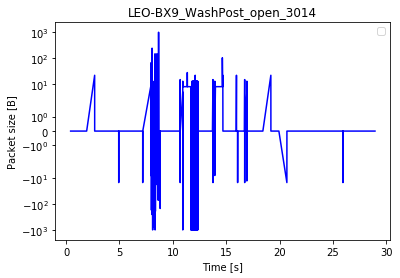

No handles with labels found to put in legend.


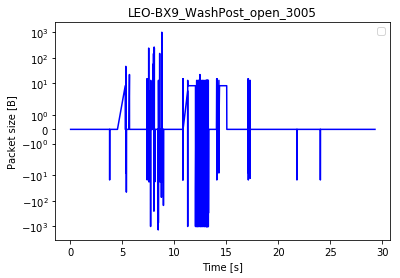

No handles with labels found to put in legend.


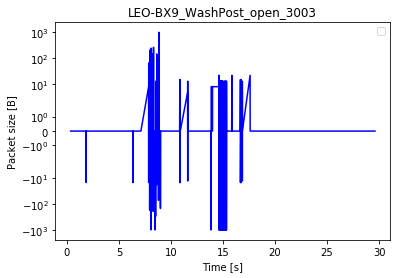

No handles with labels found to put in legend.


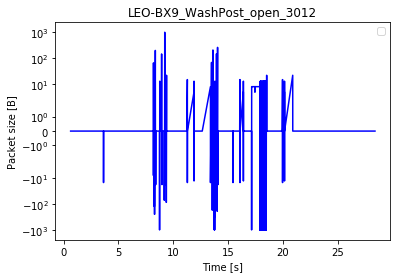

No handles with labels found to put in legend.


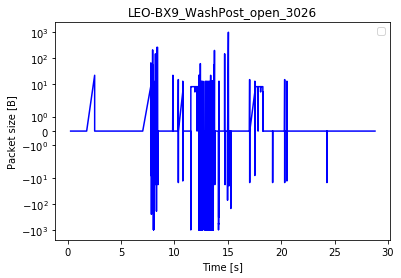

No handles with labels found to put in legend.


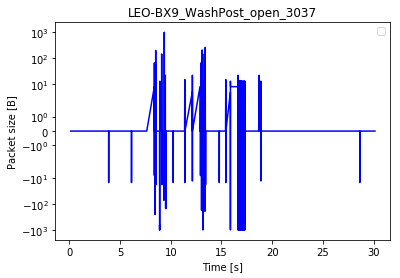

No handles with labels found to put in legend.


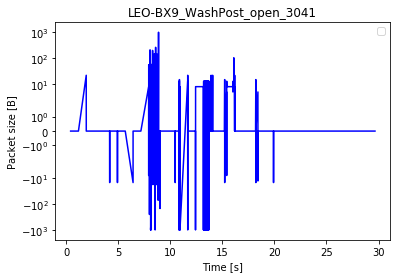

No handles with labels found to put in legend.


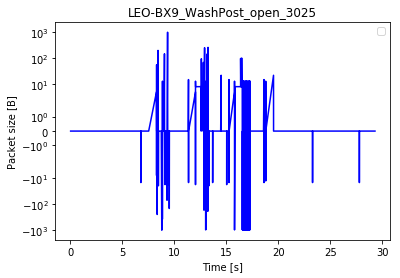

No handles with labels found to put in legend.


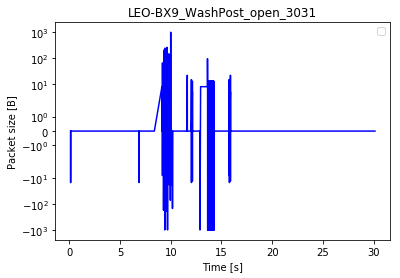

No handles with labels found to put in legend.


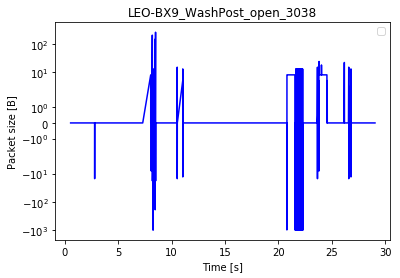

No handles with labels found to put in legend.


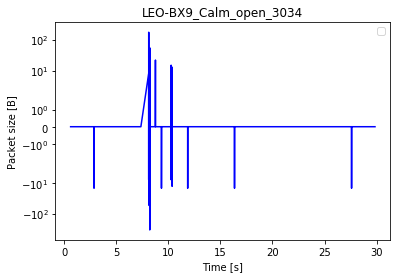

No handles with labels found to put in legend.


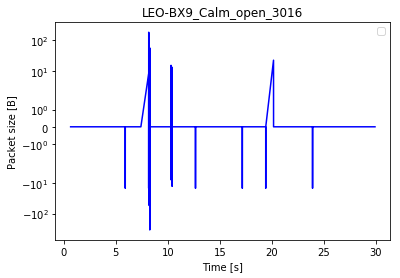

In [26]:
print("Detected representatives:")

for representative in labels_to_analysis[representative_ind]:
    plot_event(representative, datasets, 'b')

In [27]:
print(np.where(labels_to_analysis == 'LEO-BX9_WashPost_open_2012'))
np.where(labels_to_analysis == 'LEO-BX9_WashPost_open_2009')

(array([], dtype=int64),)


(array([], dtype=int64),)

### Try to identifiy if an application is sending information via Bluetooth Using ML
#### Using statistics data on NoApp_NoAction

In [46]:
NoApp_ds, NoApp_label = create_sub_dataset(datasets, N_TO_PICK = -1, AppToKeepOnly="NoApp", watch='LEO-BX9')

### TODO:

Automate action on watch, try with a single capture distinguish